In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
print(x_train.shape) # (60000, 28, 28)
print(x_test.shape) # (10000, 28, 28)
print(x_train[0].dtype) # uint8
print(x_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

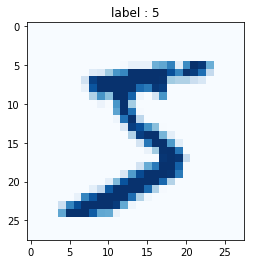

In [4]:
index = 0
image = x_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'Blues')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [5]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


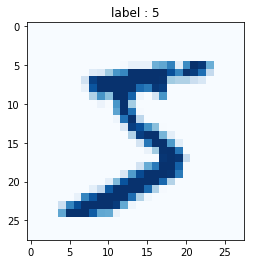

In [6]:
index = 0
image = x_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'Blues')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [7]:
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255
print(x_train.max()) # 1.0
print(x_train.min()) # 0.0

1.0
0.0


In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.4)
print(x_train.shape) # (48000, 784)
print(x_val.shape) # (12000, 784)

(36000, 784)
(24000, 784)


###### 【問題1】ニューラルネットワーク分類器のクラスを作成
ニューラルネットワーク分類器のクラスScratchSimpleNeuralNetrowkClassifierを作成してください。

In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [11]:
class NN_LayerFunction():
    #NNの層のクラス
    def __init__(self, activation_func, num_of_node):
        self.activation_func_type = activation_func
        self.num_of_node = num_of_node
        self.input_multi_func = 0
        self.input_add_func = 0
        self.input_activation_func = 0
        self.output_activation_func = 0

    def _sigmoid(self, X):
        return 1 / (1 + np.exp(-1 * X))
    
    def _tanh(self, X):
        return np.tanh(X)
    
    def _softmax(self, X):
        X = X - np.max(X)
        tmp = np.exp(X)
        denominator = np.sum(tmp, axis=1)
        output = tmp / denominator[:, np.newaxis]
        
        return output
    
    def multi_func(self, X, W):
        """
        X.shape=(X, Y)
        W.shape=(Y, Z)
        Output.shape=(X,Z)
        """
        #逆伝搬計算のため入力を保存
        self.input_multi_func = X
        return np.dot(X, W)
    
    def multi_func_backword(self, loss):
        #入力：loss, 学習率
        #計算：loss' = dot(loss, input)
        #出力：loss'
        #print("input:{} loss:{}",self.input_multi_func.shape, loss.shape)
        return np.dot(self.input_multi_func.T, loss)
    
    def add_func(self, X, B):
        """
        X.shape=(X, Y)
        B.shape=(1, Y)
        """
        #逆伝搬計算のため入力を保存
        self.input_add_func = X
        return  X + B
    
    def add_func_backword(self, loss):
        #入力：loss
        #計算：loss' = loss
        #出力：loss'
        return loss
    
    def activation_func(self, X):
        """
        X.shape=(X, Y)
        output.shape=(X, Y)
        """
        #逆伝搬計算のため入力を保存
        self.input_activation_func = X
        
        if self.activation_func_type == 'sigmoid':
            output = self._sigmoid(X)
        elif self.activation_func_type == 'tanh':
            output = self._tanh(X)
        elif self.activation_func_type == 'softmax':
            output = self._softmax(X)
        else:
            output = X
        
        #逆伝搬計算のため出力を保存
        self.output_activation_func = output
        
        return output
    
    def activation_func_backword(self, loss, weight):
        #入力：loss, 学習率
        #計算：Z = f' * loss
        #出力：Z        
        
        #活性化関数（逆伝搬）
        if self.activation_func_type == 'sigmoid':
            output = (1 - self._sigmoid(self.input_activation_func)) * self._sigmoid(self.input_activation_func)
        elif self.activation_func_type == 'tanh':
            output = 1 - (self._tanh(self.input_activation_func))**2
        elif self.activation_func_type == 'softmax':
            output = loss
        else:
            output = loss
            
        #print("prev_delta:{} weight:{}".format(loss.shape, weight.shape))
        output = output * np.dot(loss, weight.T)
        return output
    


In [12]:
default_layer_design = {
    'total_layer':3,
    'func_layer1':'sigmoid',
    'func_layer2':'sigmoid',
    'func_layer3':'softmax',
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
}
    
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, n_iter, alpha, sigma, batch_size, layer_design=default_layer_design, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.iter = n_iter
        self.alpha = alpha
        self.sigma = sigma # ガウス分布の標準偏差
        self.layer_design = layer_design
        self.NN1 = 0
        self.W1 = 0
        self.B1 = 0
        self.NN2 = 0
        self.W2 = 0
        self.B2 = 0
        self.NN3 = 0
        self.W3 = 0
        self.B3 = 0
        self.loss = 0
        self.loss_val = 0
    
    def _crossentropy(self, y_pred, y):
        #クロスエントロピーを計算する
        
        #print("y shape:{} y_pred shape:{}".format(y.shape, y_pred.shape))
        #pos_proba = -1 * y * np.log(y_pred)
        #neg_proba = -1 * (1 - y) * np.log((1 - y_pred))
        #print("pos shape:{} neg shape:{}".format(pos_proba.shape, neg_proba.shape))
        #cross_entropy = (pos_proba.sum(axis=1) + neg_proba.sum(axis=1)) / y.shape[0]
        #print("cross entropy : {}",cross_entropy.shape)
        cross_entropy = -1 * y * np.log(y_pred)
        return np.sum(cross_entropy, axis=1)
    
    def _adjust_param(self, loss, X):
        return
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        #lossの記録用の配列を用意
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.iter)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.iter)]
        
        #重みW バイアスbを入力データのサンプル数に従い準備
        n_features = X.shape[1]
        n_nodes1 = self.layer_design.get('node_layer1')
        self.W1 = self.sigma * np.random.randn(n_features, n_nodes1)
        self.B1 = self.sigma * np.random.randn(1, n_nodes1)
        
        n_nodes2 = self.layer_design.get('node_layer2')
        self.W2 = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        self.B2 = self.sigma * np.random.randn(1, n_nodes2)
        
        n_nodes3 = self.layer_design.get('node_layer3')
        self.W3 = self.sigma * np.random.randn(n_nodes2, n_nodes3)
        self.B3 = self.sigma * np.random.randn(1, n_nodes3)        
        
        #各層のインスタンスを作る
        self.NN1 = NN_LayerFunction(self.layer_design.get('func_layer1'), self.layer_design.get('node_layer1'))
        self.NN2 = NN_LayerFunction(self.layer_design.get('func_layer2'), self.layer_design.get('node_layer2'))
        self.NN3 = NN_LayerFunction(self.layer_design.get('func_layer3'), self.layer_design.get('node_layer3'))
                
        #print("W1:{} B1:{}".format(self.W1.shape, self.B1.shape))
        #print("W2:{} B2:{}".format(self.W2.shape, self.B2.shape))
        #print("W3:{} B3:{}".format(self.W3.shape, self.B3.shape))
        
        #NN計算
        #ミニバッチ取得
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.iter):
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                #１層目
                X = self.NN1.multi_func(mini_X_train, self.W1)
                X = self.NN1.add_func(X, self.B1)
                X = self.NN1.activation_func(X)

                #２層目
                X = self.NN2.multi_func(X, self.W2) #X.shape (Sample, node1)=>(Sample, node2)
                X = self.NN2.add_func(X, self.B2)   #X.shape (Sample, node2)=>(Sample, node2)
                X = self.NN2.activation_func(X)     #X.shape (Sample, node2)=>(Sample, node2)

                #３層目
                X = self.NN3.multi_func(X, self.W3) #X.shape (Sample, node2)=>(Sample, node3=10)
                X = self.NN3.add_func(X, self.B3)   #X.shape (Sample, 10)=>(Sample, 10)
                ans = self.NN3.activation_func(X)   #X.shape (Sample, 10)=>(Sample, 10)

                #Loss計算
                loss = self._crossentropy(ans, mini_y_train)  #ans.shape(Sample, 1), y.shape(Sample, 1), loss.shape(Sample, 1)
                sum_loss += loss
                #パラメータ調整(誤差逆伝搬の計算)
                #更新前のパラメータを保存
                old_B1 = np.copy(self.B1)
                old_B2 = np.copy(self.B2)
                old_B3 = np.copy(self.B3)
                old_W1 = np.copy(self.W1)
                old_W2 = np.copy(self.W2)
                old_W3 = np.copy(self.W3)

                #3層目
                delta1 = ans - mini_y_train                    #delta.shape(Sample, 10)
                b_grad = self.NN3.add_func_backword(delta1)         #delta.shape(Sample, 10)
                self.B3 = self.B3 - np.average(b_grad * self.alpha, axis=0)
                w_grad = self.NN3.multi_func_backword(delta1)       #delta.shape(Sample, node2)
                self.W3 = self.W3 - self.alpha * w_grad / delta1.shape[0]
                #2層目
                delta2 = self.NN2.activation_func_backword(delta1, old_W3)  #delta.shape(Sample, node1)            
                b_grad = self.NN2.add_func_backword(delta2)    #delta.shape(Sample, node2)
                self.B2 = self.B2 - np.average(b_grad * self.alpha, axis=0)
                w_grad = self.NN2.multi_func_backword(delta2)  #delta.shape(Sample, node1)
                self.W2 = self.W2 - self.alpha * w_grad / delta2.shape[0]
                #1層目
                delta3 = self.NN1.activation_func_backword(delta2, old_W2)  #delta.shape(Sample, Feature)
                b_grad = self.NN1.add_func_backword(delta3)    #delta.shape(Sample, node1)
                self.B1 = self.B1 - np.average(b_grad * self.alpha, axis=0)
                w_grad = self.NN1.multi_func_backword(delta3)  #delta.shape(Sample, Feature)
                self.W1 = self.W1 - self.alpha * w_grad / delta3.shape[0]
                
                loop_count += 1

            #Epoch毎のLoss計算結果表示
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)            
            
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch:{} Loss:{} Loss(val):{}".format(i, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        #１層目
        X = self.NN1.multi_func(X, self.W1)
        X = self.NN1.add_func(X, self.B1)
        X = self.NN1.activation_func(X)              
        #２層目
        X = self.NN2.multi_func(X, self.W2)
        X = self.NN2.add_func(X, self.B2)
        X = self.NN2.activation_func(X)
        #３層目
        X = self.NN3.multi_func(X, self.W3)
        X = self.NN3.add_func(X, self.B3)
        ans = self.NN3.activation_func(X)
        
        max_val = np.max(ans, axis=1)
        mask = np.ones_like(ans)
        ans[ans == max_val[:,np.newaxis]] = 1
        ans[ans != mask] = 0

        return ans
    
    def _predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        #１層目
        X = self.NN1.multi_func(X, self.W1)
        X = self.NN1.add_func(X, self.B1)
        X = self.NN1.activation_func(X)              
        #２層目
        X = self.NN2.multi_func(X, self.W2)
        X = self.NN2.add_func(X, self.B2)
        X = self.NN2.activation_func(X)
        #３層目
        X = self.NN3.multi_func(X, self.W3)
        X = self.NN3.add_func(X, self.B3)
        ans = self.NN3.activation_func(X)

        return ans

In [13]:
layer_design = {
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
}

In [14]:
nn_clf = ScratchSimpleNeuralNetrowkClassifier(5, 0.1, 0.01, 10, layer_design, False)

In [15]:
nn_clf.fit(x_train, y_train, x_val, y_val)

###### 【問題2】学習曲線のプロット

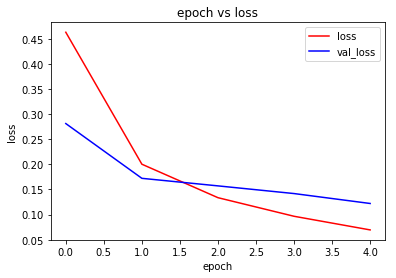

In [16]:
loss = np.array(nn_clf.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(nn_clf.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
#plt.yscale("Log")
plt.show()

###### 【問題3】指標値の算出

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [18]:
y_pred = nn_clf.predict(x_val)

In [19]:
print("Pred=\n", y_pred[1])
print("Yval=\n", y_val[2])

Pred=
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Yval=
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))
#print("Precision score={:.3f}".format(precision_score(y_pred, y_val, average='micro')))
#print("Recall score={:.3f}".format(recall_score(y_pred, y_val, average='micro')))
#print("f1 score={:.3f}".format(f1_score(y_pred, y_val, average='micro')))

Accuracy score=0.964


###### （オプション）誤分類の確認

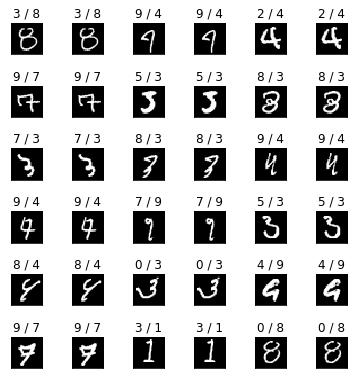

In [22]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt

num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(np.argmax(y_pred[false_list[i]]),np.argmax(y_val[false_list[i]])))
    ax.imshow(x_val.reshape(-1,28,28)[false_list[i]], cmap='gray')